# G(PO)MDP

This notebook is inspired to the Stable Baselines3 tutorial available at [https://github.com/araffin/rl-tutorial-jnrr19](https://github.com/araffin/rl-tutorial-jnrr19).


## Introduction

In this notebook, we will learn how to build a customized environment with **Gymnasium**.

### Links

Gymnasium Github: [https://github.com/Farama-Foundation/Gymnasium](https://github.com/Farama-Foundation/Gymnasium)

Gymnasium Documentation: [https://gymnasium.farama.org/index.html](https://gymnasium.farama.org/index.html#)

Stable Baselines 3 Github:[https://github.com/DLR-RM/stable-baselines3](https://github.com/DLR-RM/stable-baselines3)

Stable Baseline 3 Documentation: [https://stable-baselines3.readthedocs.io/en/master/](https://stable-baselines3.readthedocs.io/en/master/)

## Install Gymnasium and Stable Baselines3 Using Pip

In [1]:
!pip install gymnasium
!pip install renderlab  #For rendering
!pip install stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 10.1 MB/s eta 0:00:00


In [3]:
import gymnasium as gym
import renderlab
import stable_baselines3

print(gym.__version__)
print(stable_baselines3.__version__)

1.2.3
2.7.1


In [6]:
def evaluate(env, policy, gamma=1., num_episodes=100):
    """
    Evaluate a RL agent
    :param env: (Env object) the Gym environment
    :param policy: (BasePolicy object) the policy in stable_baselines3
    :param gamma: (float) the discount factor
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    all_episode_rewards = []
    for i in range(num_episodes): # iterate over the episodes
        episode_rewards = []
        done = False
        discounter = 1.
        obs, _ = env.reset()
        while not done: # iterate over the steps until termination
            action, _ = policy.predict(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_rewards.append(reward * discounter) # compute discounted reward
            discounter *= gamma

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    std_episode_reward = np.std(all_episode_rewards) / np.sqrt(num_episodes - 1)
    print("Mean reward:", mean_episode_reward,
          "Std reward:", std_episode_reward,
          "Num episodes:", num_episodes)

    return mean_episode_reward, std_episode_reward

## Plotting

A helper function to plot the learning curves.

In [19]:
import matplotlib.pyplot as plt


def plot_results(results):
    plt.figure()

    _mean = []
    _std = []
    for m, s in results:
        _mean.append(m)
        _std.append(s)

    _mean = np.array(_mean)
    _std = np.array(_std)

    ts = np.arange(len(_mean))
    plt.plot(ts, _mean, label='G(PO)MDP')
    plt.fill_between(ts, _mean-_std, _mean+_std, alpha=.2)

    plt.xlabel('Trajectories')
    plt.ylabel('Average return')
    plt.legend(loc='lower right')

    plt.show()

## G(PO)MDP

![ss](https://github.com/albertometelli/rl-phd-2026/blob/main/gpomdp.png?raw=1)

**References**

Baxter, Jonathan, and Peter L. Bartlett. "Infinite-horizon policy-gradient estimation." Journal of Artificial Intelligence Research 15 (2001): 319-350.

## Policy

We will use a Gaussian policy, linear in the state variables and with fixed (non-learnable) standard deviation.

$$
\pi_{\boldsymbol{\theta}}(a|\mathbf{s}) = {N}(a| \boldsymbol{\theta}^T \mathbf{s}, \sigma^2)
$$

The policy must implement the usual `predict` method and some additional methods for computing the policy gradient. Specifically, we will need a `grad_log` method to return the gradient of the logarithm of the policy (the score):

$$
\nabla_{\boldsymbol{\theta}} \log \pi_{\boldsymbol{\theta}}(a|\mathbf{s})= \frac{(a - \boldsymbol{\theta}^T \mathbf{s})\mathbf{s}}{\sigma^2}
$$

## Exercise 1

Complete the implementation of the methods `predict` and `grad_log`

In [18]:
class GaussianPolicy:

    def __init__(self, dim, std=0.1):
        """
        :param dim: number of state variables
        :param std: fixed standard deviation
        """

        self.std = std
        self.dim = dim
        self.theta = np.zeros((dim,))  # zero initializatoin

    def get_theta(self):
        return self.theta

    def set_theta(self, value):
        self.theta = value

    def predict(self, obs):
        """
        :param obs: (ndarray) the state observation (dim,)
        :return: the sampled action and the same observation
        """
        mean = np.matmul(self.theta, obs)
        std = self.std
        action = np.random.normal(mean, std)
        return np.array([action]), obs

    def grad_log(self, obs, action):
        """
        :param obs: (ndarray) the state observation (dim,)
        :param action: (float) the action
        :return: (ndarray) the score of the policy (dim,)
        """
        num = (action - np.matmul(self.theta, obs)) * obs
        den = self.std ** 2
        grad_log = num/ den

        #TODO

        return grad_log

## Training Routine

We provide the already implemented skeleton of the training routine that samples at every iterations $m$ trajectories from the environment.

In [11]:
def collect_rollouts(env, policy, m, T):
    """
    Collects m rollouts by running the policy in the
        environment
    :param env: (Env object) the Gym environment
    :param policy: (Policy object) the policy
    :param gamma: (float) the discount factor
    :param m: (int) number of episodes per iterations
    :param K: (int) maximum number of iterations
    :param theta0: (ndarray) initial parameters (d,)
    :param alpha: (float) the constant learning rate
    :param T: (int) the trajectory horizon
    :return: (list of lists) one list per episode
                each containing triples (s, a, r)
    """

    ll = []
    for j in range(m):
        s, _ = env.reset()
        t = 0
        done = False
        l = []
        while t < T and not done:
            a, _ = policy.predict(s)
            s1, r, done, _, _ = env.step(a)
            l.append((s, a, r))
            s = s1
            t += 1
        ll.append(l)
    return ll

def train(env, policy, gamma, m, K, alpha, T):
    """
    Train a policy with G(PO)MDP
    :param env: (Env object) the Gym environment
    :param policy: (Policy object) the policy
    :param gamma: (float) the discount factor
    :param m: (int) number of episodes per iterations
    :param K: (int) maximum number of iterations
    :param alpha: (float) the constant learning rate
    :param T: (int) the trajectory horizon
    :return: list (ndarray, ndarray) the evaluations
    """

    results = []

    # Evaluate the initial policy
    res = evaluate(env, policy, gamma)
    results.append(res)

    for k in range(K):

        print('Iteration:', k)

        # Generate rollouts
        rollouts = collect_rollouts(env, policy, m, T)

        # Get policy parameter
        theta = policy.get_theta()

        # Call your G(PO)MDP estimator
        pg = gpomdp(rollouts, policy, gamma)

        # Update policy parameter
        theta = theta + alpha * pg

        # Set policy parameters
        policy.set_theta(theta)

        # Evaluate the updated policy
        res = evaluate(env, policy, gamma)
        results.append(res)

    return results

## Exercise 2

Complete the following function `gpomdp` that computes the G(PO)MDP gradient estimator given rollout trajectories.

In [45]:
import numpy as np
def gpomdp(rollouts, policy, gamma):
    """
    :param rollouts: (list of lists) generated by 'collect_rollouts'
    :param policy: (Policy object) the policy
    :param gamma: (float) the discount factor
    :return: (ndarray) the policy gradient (dim,)

    """
    policy_grad_computations = [np.array([policy.grad_log(rollouts[i][k][0], rollouts[i][k][1]) for k in range(len(rollouts[i])) ]) for i in range(len(rollouts))]
    g = np.zeros((len(rollouts), 2))
    for i in range(len(rollouts)):
        for t in range(len(rollouts[i])):
            s, a, r = rollouts[i][t]
            # print(policy_grad_computations[i][:t+1].shape)
            summ = np.sum(policy_grad_computations[i][:t+1], axis = 0)
            # print(summ.shape)
            g[i] += (gamma ** t) * r * summ


    #TODO
    grad = np.mean(g, axis=0)
    return grad

## Test our Implementation

We test our G(PO)MDP implementation over the `MountainCarContinuous-v0` environment.

MountainCarContinuous Environment Decription: [https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/)

MountainCarContinuous Source Code: [https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/continuous_mountain_car.py](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/continuous_mountain_car.py)

We consider a modified simpler version

In [46]:
import gymnasium as gym
from gymnasium.envs.classic_control.continuous_mountain_car import Continuous_MountainCarEnv
from gymnasium.envs.registration import register
from typing import Optional


class SimplifiedContinuous_MountainCarEnv(Continuous_MountainCarEnv):

    def __init__(self, render_mode: Optional[str] = None, goal_velocity=0):
        super(SimplifiedContinuous_MountainCarEnv, self).__init__(render_mode, goal_velocity)

        # We make the environment a little bit simpler by increasing the power
        self.power =  0.02


register(
    id="SimplifiedMountainCarContinuous-v1",
    entry_point="__main__:SimplifiedContinuous_MountainCarEnv",
    max_episode_steps=200,
    reward_threshold=100,
)

  logger.warn(f"Overriding environment {new_spec.id} already in registry.")



In [47]:
import numpy as np


# Instantiate the environment
env = gym.make('SimplifiedMountainCarContinuous-v1')

env_eval = gym.make('SimplifiedMountainCarContinuous-v1', render_mode = "rgb_array")
env_eval = renderlab.RenderFrame(env_eval, "./output")

# Instantiate the policy
policy = GaussianPolicy(env.observation_space.shape[0], std=0.2)

gamma = 0.999  # discount factor
m = 100        # number of trajectories per iteration
K = 100        # maximum number of iterations
alpha = 0.001  # learning rate
T = 200        # lenght of each trajectory

# Start training
results = train(env, policy, gamma, m, K, alpha, T)

Mean reward: 18.551920407194995 Std reward: 3.6527331879818052 Num episodes: 100
Iteration: 0
Mean reward: 34.17653657881016 Std reward: 4.317461297429205 Num episodes: 100
Iteration: 1
Mean reward: 35.88527095794896 Std reward: 4.335723032075769 Num episodes: 100
Iteration: 2
Mean reward: 33.50484273029426 Std reward: 4.311157569724097 Num episodes: 100
Iteration: 3
Mean reward: 36.00147184776914 Std reward: 4.344254349190075 Num episodes: 100
Iteration: 4
Mean reward: 33.5538177250817 Std reward: 4.311931476926261 Num episodes: 100
Iteration: 5
Mean reward: 60.14853087320054 Std reward: 4.223066500467365 Num episodes: 100
Iteration: 6
Mean reward: 53.84555907305851 Std reward: 4.416567776317596 Num episodes: 100
Iteration: 7
Mean reward: 54.39470120636741 Std reward: 4.357364513649702 Num episodes: 100
Iteration: 8
Mean reward: 63.21302891292905 Std reward: 4.128066483953256 Num episodes: 100
Iteration: 9
Mean reward: 66.405817307114 Std reward: 3.925826646681802 Num episodes: 100
It

Let us render the results.

In [48]:
perf_mean, perf_std = evaluate(env, policy)

evaluate(env_eval, policy, num_episodes=1)
env_eval.play()

Mean reward: 99.24155758769207 Std reward: 0.055752791505341674 Num episodes: 100


  std_episode_reward = np.std(all_episode_rewards) / np.sqrt(num_episodes - 1)



Mean reward: 98.25902519910599 Std reward: nan Num episodes: 1
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:  77%|███████▋  | 88/114 [00:00<00:00, 321.28it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./output/1771585240.7035391.mp4, 720000 bytes wanted but 0 bytes read,at frame 113/114, at time 3.77/3.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


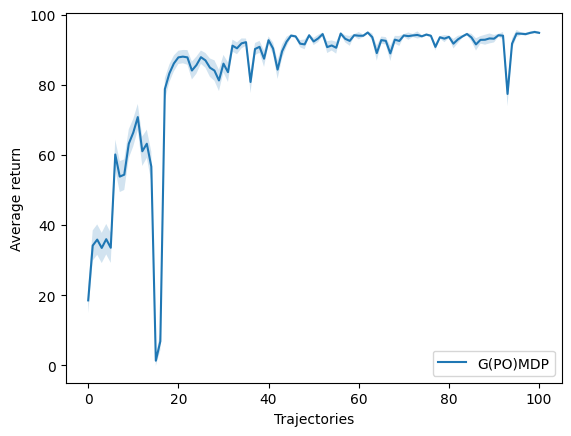

In [49]:
plot_results(results)

In [50]:
import numpy as np


# Instantiate the environment
env = gym.make('SimplifiedMountainCarContinuous-v1')

env_eval = gym.make('SimplifiedMountainCarContinuous-v1', render_mode = "rgb_array")
env_eval = renderlab.RenderFrame(env_eval, "./output")

# Instantiate the policy
policy = GaussianPolicy(env.observation_space.shape[0], std=0.2)

gamma = 0.999  # discount factor
m = 100        # number of trajectories per iteration
K = 100        # maximum number of iterations
alpha = 0.01  # learning rate
T = 200        # lenght of each trajectory

# Start training
results = train(env, policy, gamma, m, K, alpha, T)

Mean reward: 19.11406758257433 Std reward: 3.650217044998808 Num episodes: 100
Iteration: 0
Mean reward: 8.511708798992139 Std reward: 3.12129507247339 Num episodes: 100
Iteration: 1
Mean reward: 57.629000487602276 Std reward: 4.551256560037416 Num episodes: 100
Iteration: 2
Mean reward: 89.31960748938965 Std reward: 1.9246768601363802 Num episodes: 100
Iteration: 3
Mean reward: -10.329696869585597 Std reward: 0.060456268466351 Num episodes: 100
Iteration: 4
Mean reward: -9.824406810998854 Std reward: 0.05447949199362962 Num episodes: 100
Iteration: 5
Mean reward: -10.010172652068398 Std reward: 0.055197540686979116 Num episodes: 100
Iteration: 6
Mean reward: -9.711144317650046 Std reward: 0.057190433078188704 Num episodes: 100
Iteration: 7
Mean reward: -9.803248947528324 Std reward: 0.06219173174399467 Num episodes: 100
Iteration: 8
Mean reward: -9.672273895939549 Std reward: 0.0642954774432118 Num episodes: 100
Iteration: 9
Mean reward: -10.151609392939063 Std reward: 0.0684823829462

In [51]:
perf_mean, perf_std = evaluate(env, policy)

evaluate(env_eval, policy, num_episodes=1)
env_eval.play()

Mean reward: -9.368761355552365 Std reward: 0.2262728116364579 Num episodes: 100


  std_episode_reward = np.std(all_episode_rewards) / np.sqrt(num_episodes - 1)



Mean reward: -13.721476000080115 Std reward: nan Num episodes: 1
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [54]:
import numpy as np


# Instantiate the environment
env = gym.make('SimplifiedMountainCarContinuous-v1')

env_eval = gym.make('SimplifiedMountainCarContinuous-v1', render_mode = "rgb_array")
env_eval = renderlab.RenderFrame(env_eval, "./output")

# Instantiate the policy
policy = GaussianPolicy(env.observation_space.shape[0], std=0.2)

gamma = 0.999  # discount factor
m = 200        # number of trajectories per iteration
K = 200        # maximum number of iterations
alpha = 0.001  # learning rate
T = 400        # lenght of each trajectory

# Start training
results = train(env, policy, gamma, m, K, alpha, T)

Mean reward: 19.472245804887248 Std reward: 3.718302662712987 Num episodes: 100
Iteration: 0
Mean reward: 38.038909042621285 Std reward: 4.465171661850078 Num episodes: 100
Iteration: 1
Mean reward: 46.168522998636334 Std reward: 4.499917453711109 Num episodes: 100
Iteration: 2
Mean reward: 46.957073153010384 Std reward: 4.576540394894384 Num episodes: 100
Iteration: 3
Mean reward: 58.44031244003973 Std reward: 4.319623927584515 Num episodes: 100
Iteration: 4
Mean reward: 62.64320600882816 Std reward: 4.119174156687039 Num episodes: 100
Iteration: 5
Mean reward: 64.57019059231172 Std reward: 4.048543455398599 Num episodes: 100
Iteration: 6
Mean reward: 70.80346157582304 Std reward: 3.7746911740263167 Num episodes: 100
Iteration: 7
Mean reward: 64.01910486918018 Std reward: 4.27192926504577 Num episodes: 100
Iteration: 8
Mean reward: 63.22457367663719 Std reward: 4.245727190891443 Num episodes: 100
Iteration: 9
Mean reward: 64.02892672396376 Std reward: 4.182629222760443 Num episodes: 1